## Class Test to understand __get_item__



In [1]:


import numpy as np

class MyMedicalDataset:
    def __init__(self, image_paths, labels, transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        
        return len(self.image_paths)

    def __getitem__(self, idx):
       
        # When you do dataset[i], this method is called with idx = i

        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # In a real scenario, you'd load the image (e.g., DICOM with pydicom/MONAI LoadImage)
        # For simplicity, let's pretend we load a dummy image
        image_data = np.random.rand(64, 64) # Simulate loading an image

        # Apply transforms if provided (e.g., MONAI transforms)
        if self.transforms:
            # MONAI transforms expect dictionaries
            data_dict = {"image": image_data, "label": label}
            data_dict = self.transforms(data_dict)
            image_data = data_dict["image"]
            label = data_dict["label"]

        return {"image": image_data, "label": label}

# --- Usage Example ---
image_files = ["img1.dcm", "img2.dcm", "img3.dcm"]
labels_data = [0, 1, 0]

# Imagine some MONAI transforms here
from monai.transforms import RandFlip, Compose, AsDiscrete, EnsureChannelFirstd

 #my_transforms = Compose([
#     EnsureChannelFirstd(keys="image"),
#     RandFlip(prob=0.5, spatial_axis=None)
    
# ])


dataset = MyMedicalDataset(image_files, labels_data, transforms=None)

# This calls dataset.__getitem__(0)
first_item = dataset[0]
print(f"Type of first_item: {type(first_item)}")
print(f"Keys in first_item: {first_item.keys()}")
print(f"Shape of first_item['image']: {first_item['image'].shape}")

# This calls dataset.__len__()
print(f"Dataset length: {len(dataset)}")

# This indirectly uses __getitem__ (and __len__) for iteration
for i in range(len(dataset)):
    item = dataset[i]
    print(f"Processing item {i}")

# Test on the class itself 
print(f"images path : {dataset.image_paths}" )
print(f"labels : {dataset.labels}")
print(f"Transforms : {dataset.transforms}")

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Type of first_item: <class 'dict'>
Keys in first_item: dict_keys(['image', 'label'])
Shape of first_item['image']: (64, 64)
Dataset length: 3
Processing item 0
Processing item 1
Processing item 2
images path : ['img1.dcm', 'img2.dcm', 'img3.dcm']
labels : [0, 1, 0]
Transforms : None


## RSNA class


In [2]:
from torch.utils.data import Dataset
import pydicom
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import monai.transforms as T

def safe_get_first(value, default):
    try:
        if isinstance(value, pydicom.multival.MultiValue):
            return float(value[0])
        else:
            return float(value)
    except Exception:
        return float(default)
    

class RSNA_DICOM_Dataset_V0(Dataset):
    def __init__(self, csv_path, dicom_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.dicom_dir = Path(dicom_dir)
        self.transform = transform
        self.label_cols = [ 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        self.loader = T.LoadImage(image_only=False)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dcm_path = self.dicom_dir / row['filename']
        dcm = pydicom.dcmread(str(dcm_path))

        # Load image
        image, meta = self.loader(str(dcm_path)) # Using MONAI's LoadImage

        dicom_raw = pydicom.dcmread(str(dcm_path))

        center = safe_get_first(getattr(dcm, 'WindowCenter', 40), 40)
        width = safe_get_first(getattr(dcm, 'WindowWidth', 80), 80)
        slope = safe_get_first(getattr(dcm, 'RescaleSlope', 1), 1)
        intercept = safe_get_first(getattr(dcm, 'RescaleIntercept', 0), 0)
        

        img_np = image.astype(np.float32)
        img_np = img_np * slope + intercept

        img_windowed = np.clip(img_np, center - width // 2, center + width // 2)
        img_norm = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min() + 1e-5)

        # ==== 4. Conversion en tenseur PyTorch + ajout canal (C, H, W)
        img_tensor = torch.from_numpy(img_norm).float().unsqueeze(0)  # [1, H, W]

        # ==== 5. Resize etc.
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # ==== 6. Extraction des labels
        label = torch.tensor(row[self.label_cols].values.astype(np.float32))
        # print("DICOM path:", dcm_path)
        # print("Row filename:", row['filename'])
        # print("Row labels:", row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])  
        return img_tensor, label

# Inspecting attr after 36th samples  in the dataset:

import pydicom
from pathlib import Path

def safe_get_float(value, default):
    if isinstance(value, pydicom.multival.MultiValue):
        return float(value[0])
    try:
        return float(value)
    except Exception:
        return float(default)
# --- Paths ---
csv_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification_RSNA/data/csv/train_fold0.csv")
dicom_dir = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification_RSNA/data/rsna-intracranial-hemorrhage-detection/stage_2_train")

import pandas as pd
df = pd.read_csv(csv_path)

# Sample index
i = 47
dcm_path = Path(dicom_dir) / df.iloc[i]["filename"]
dcm = pydicom.dcmread(str(dcm_path))
dicom_raw = pydicom.dcmread(str(dcm_path))
# Safe attribute reads
center = (dicom_raw.WindowCenter)
print("center", center)
width = (dicom_raw.WindowWidth)
print("width", width)
slope = (dicom_raw.RescaleSlope)
print("slope", slope)
intercept = float(dicom_raw.RescaleIntercept)
print("intercept", intercept)


# Safe attribute reads
center_2 = safe_get_float(getattr(dcm, 'WindowCenter', 40), 40)
width_2 = safe_get_float(getattr(dcm, 'WindowWidth', 80), 80)
slope_2 = safe_get_float(getattr(dcm, 'RescaleSlope', 1), 1)
intercept_2 = safe_get_float(getattr(dcm, 'RescaleIntercept', 0), 0)

print("center_2", center_2)
print("width_2", width_2)
print("slope_2", slope_2)
print("intercept_2", intercept_2)

center [00036, 00036]
width [00080, 00080]
slope 1
intercept -1024.0
center_2 36.0
width_2 80.0
slope_2 1.0
intercept_2 -1024.0


In [3]:
import os
os.cpu_count()

48

In [2]:
from torch.utils.data import Dataset
import pydicom
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import monai.transforms as T


    

class RSNA_DICOM_Dataset(Dataset):
    def __init__(self, csv_path, dicom_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.dicom_dir = Path(dicom_dir)
        self.transform = transform
        self.label_cols = [ 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        self.loader = T.LoadImage(image_only=True)

        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dcm_path = self.dicom_dir / row['filename']
        

        # Load image
        image = self.loader(str(dcm_path)) # Using MONAI's LoadImage

        #print("Image shape:", image.shape)
        # transform
        if self.transform:
            img_tensor = self.transform(image)
            #print("Transformed image shape:", img_tensor.shape)

        # label extraction
        label = torch.tensor(row[self.label_cols].values.astype(np.float32))
        # print("DICOM path:", dcm_path)
        # print("Row filename:", row['filename'])
        # print("Row labels:", row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])  
        return img_tensor, label


In [ ]:
# Replace the class by another pipeline to use PersistentDataset


In [5]:
#Vérifif alignement entre csv et get_item

csv_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification_RSNA/data/csv/train_fold0.csv")
df = pd.read_csv(csv_path)

print(df.iloc[1001])


filename            ID_357ebf7aa.dcm
any                                1
epidural                           0
intraparenchymal                   0
intraventricular                   1
subarachnoid                       0
subdural                           1
PatientID                ID_00760731
Name: 1001, dtype: object


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

0
80
Number of samples in the dataset: 539469
torch.Size([1, 224, 224])
tensor([0., 0., 0., 0., 0., 0.])
Label shape: torch.Size([6])
Image shape: (224, 224)


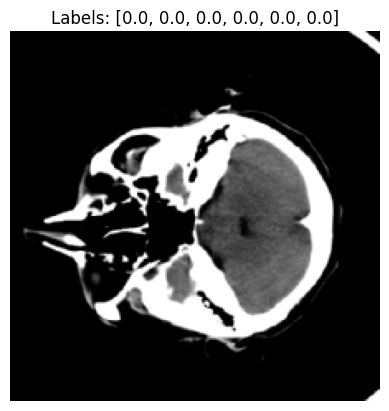

In [5]:

import matplotlib.pyplot as plt
window_preset = {"window_center": 40, "window_width": 80}

print( window_preset["window_center"] - window_preset["window_width"]//2)
print( window_preset["window_center"] + window_preset["window_width"]//2)

train_transforms = T.Compose([
    T.ScaleIntensityRange(
        a_min=window_preset["window_center"] - window_preset["window_width"]//2,
        a_max=window_preset["window_center"] + window_preset["window_width"]//2,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    T.EnsureChannelFirst(),
    T.Resize((224, 224))
])
csv_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification_RSNA/data/csv/train_fold0.csv")
dicom_dir = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification_RSNA/data/rsna-intracranial-hemorrhage-detection/stage_2_train")
train_dataset = RSNA_DICOM_Dataset(csv_path, dicom_dir, transform=train_transforms)
print(f"Number of samples in the dataset: {len(train_dataset)}")

image, label = train_dataset[10030]
print(image.shape)  # [1, 224, 224]
print(label)  
print(f"Label shape: {label.shape}")
image_np = image.squeeze().numpy()  # Convert to numpy array for visualization
print(f"Image shape: {image_np.shape}")  # Should be [1, 224, 224]
# Affichage
plt.imshow(image_np, cmap='gray')
plt.title(f"Labels: {label.tolist()}")
plt.axis('off')
plt.show()  

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from monai.networks.nets import densenet121
from monai.transforms import Compose, Resize, ToTensor
from monai.data import DataLoader, PersistentDataset, Dataset
from tqdm import tqdm
import os
# === Hyperparams ===

NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 3
LR = 1e-3

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,persistent_workers= True,pin_memory=True)
print(f"Using device: {DEVICE}")
print(f"Number of Batches in the dataset: {len(train_loader)}")

# === Model ===
model = densenet121(spatial_dims=2, in_channels=1, out_channels=NUM_CLASSES)
model.to(DEVICE)
print (model)
# === Loss (Inspiré Al )

pos_weights = torch.tensor([1.0] * NUM_CLASSES, dtype=torch.float).to(DEVICE)
print(f"répartition des poids : {pos_weights}")
loss_fn= nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# === Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

TypeError: PersistentDataset.__init__() got an unexpected keyword argument 'batch_size'

In [7]:
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device:torch.device=None):
    total_time=end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def compute_accuracy(y_pred, y_true, threshold=0.5):
    """
    Renvoie l'accuracy multilabel (exact match pour chaque label indépendamment).
    """
    preds = torch.sigmoid(y_pred) > threshold
    #print(f"preds: {preds}")
    correct = (preds == y_true.bool()).float()
    #print(f"correct: {correct}")
    return correct.mean().item()

y_pred= torch.tensor([0, 0, 1, 1, 1, 1], dtype=torch.float)
print("y_pred:", y_pred)
y_true = torch.tensor([1, 0, 1, 0, 1, 0], dtype=torch.float)
accuracy = compute_accuracy(y_pred, y_true)
print(f"Accuracy: {accuracy:.4f}")

y_pred: tensor([0., 0., 1., 1., 1., 1.])
Accuracy: 0.5000


In [8]:
def train_step(model:torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim,
                compute_accuracy,
                device:torch.device=DEVICE):
   
    train_loss,train_acc=0,0


    model.train()

    for batch,(X,y) in enumerate(dataloader):
     
      X,y=X.to(device),y.to(device)

      #1. forward pass (output the raw logits from the model )
      y_pred=model(X)

      #2. Calculate loss and accuracy (per batch)
      loss=loss_fn(y_pred,y)
      train_loss += loss
      train_acc += compute_accuracy(y_pred=y_pred,y_true=y) # go from logits -> prediction labels

      #3. Optimizer zero grad 
      optimizer.zero_grad()

      #4. Loss backward
      loss.backward()

      #5. Optimizer step
      
      optimizer.step()
      #Divide total train loss and acc by lenght of train dataloader
    
      if (batch % 400 == 0):
        print(f"Looked at {batch * len(X)}/{len(dataloader.dataset)} samples")
      
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.4f}")


def val_step(model:torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                compute_accuracy,
                device:torch.device=DEVICE):
    """Performs a testing loop step on model going over data_loader"""
   
    test_loss,test_acc=0,0


    model.eval()

    with torch.inference_mode():
      for batch,(X_test,y_test) in enumerate(dataloader):
     
        X_test,y_test=X_test.to(device),y_test.to(device)

      #1. forward pass (output the raw logits from the model )
        test_pred=model(X_test)

      #2. Calculate loss and accuracy (per batch)
        loss=loss_fn(test_pred,y_test)
        test_loss += loss
        test_acc += compute_accuracy(y_true=y_test,y_pred=test_pred) # go from logits -> prediction labels
     
        if (batch % 400 == 0):
          print(f"Looked at {batch * len(X_test)}/{len(dataloader.dataset)} samples")
    #Divide total test loss and acc by lenght of test dataloader
      test_loss /= len(dataloader)
      test_acc /= len(dataloader)

      print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.4f}")

In [ ]:
# # === Training Loop ===
# from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model,
               dataloader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               compute_accuracy=compute_accuracy,
               device=DEVICE)
    

end_time = timer()
total_train_time = print_train_time(start_time, end_time, DEVICE)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/539469 samples


  0%|          | 0/3 [00:06<?, ?it/s]
Exception in thread Thread-8 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/tibia/.pyenv/versions/3.12.9/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/tibia/.pyenv/versions/3.12.9/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tibia/.pyenv/version

KeyboardInterrupt: 

: 

In [ ]:
  ## Testing
# --- Paths ---
csv_path = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/csv/val_fold0.csv"
dicom_dir = "/home/tibia/Projet_Hemorragie/Classification/RSNA2019_Intracranial-Hemorrhage-Detection/2DNet/data/rsna-intracranial-hemorrhage-detection/stage_2_train"

val_dataset = RSNA_DICOM_Dataset(csv_path, dicom_dir, transform=resize_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)
print(f"Number of samples in the validation dataset: {len(val_dataset)}")
# Testing the model
print("Testing the model...")
# test_step(model=model,
#           dataloader=val_loader,
#           loss_fn=loss_fn,
#           compute_accuracy=compute_accuracy,
#           device=DEVICE)

Number of samples in the validation dataset: 134788


In [2]:
from torchmetrics.classification  import MultilabelAUROC, MultilabelSpecificity, MultilabelRecall
import torch




NUM_CLASSES = 6
 
 
 
      # Set up per-class metrics
Auc = MultilabelAUROC(num_labels=NUM_CLASSES , average=None)
specificity = MultilabelSpecificity(num_labels=NUM_CLASSES , threshold=0.5, average=None)
recall = MultilabelRecall(num_labels=NUM_CLASSES , threshold=0.5, average=None)

        # Also keep track of mean metrics for convenience
mean_auc = MultilabelAUROC(num_labels=NUM_CLASSES)
mean_specificity = MultilabelSpecificity(num_labels=NUM_CLASSES , threshold=0.5)
mean_recall = MultilabelRecall(num_labels=NUM_CLASSES , threshold=0.5)


target = torch.tensor([[0, 0, 1, 1, 1, 1]])
preds = torch.tensor([[1, 0, 1, 0, 1, 0]])

# Appel correct
spe = specificity(preds.float(), target.int())
print(spe)

mean_spe = mean_specificity(preds.float(), target.int())
print(mean_spe)

recall= recall(preds.float(), target.int())
print(recall)

mean_recall = mean_recall(preds.float(), target.int())
print(mean_recall)

auc= Auc(preds.float(), target.int())
print(auc)


tensor([0., 1., 0., 0., 0., 0.])
tensor(0.1667)
tensor([0., 0., 1., 0., 1., 0.])
tensor(0.3333)
tensor([0., 0., 0., 0., 0., 0.])


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


In [ ]:
from torchmetrics.classification import MultilabelAUROC, MultilabelSpecificity, MultilabelRecall,MultilabelPrecision,MultilabelAccuracy
import torch

# Configuration
NUM_CLASSES = 6
CLASS_NAMES = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device = DEVICE):
    
    # Initialisation des métriques
    auc_metric = MultilabelAUROC(num_labels=NUM_CLASSES, average=None).to(device)
    specificity_metric = MultilabelSpecificity(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    recall_metric = MultilabelRecall(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    precision_metric = MultilabelPrecision(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    accuracy_metric = MultilabelAccuracy(num_classes=NUM_CLASSES, average=None).to(device)
    
    mean_auc_metric = MultilabelAUROC(num_labels=NUM_CLASSES, average="macro").to(device)
    mean_specificity_metric = MultilabelSpecificity(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_recall_metric = MultilabelRecall(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_precision_metric = MultilabelPrecision(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_accuracy_metric = MultilabelAccuracy(num_classes=NUM_CLASSES, average="macro").to(device)  

    model.train()
    train_loss = 0.0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        
        # zero grad
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()
        
        
        y_probs = torch.sigmoid(y_logits)
        
        # Update metrics
        auc_metric.update(y_probs, y.int())
        specificity_metric.update(y_probs, y.int())
        recall_metric.update(y_probs, y.int())
        precision_metric.update(y_probs, y.int())
        accuracy_metric.update(y_probs, y.int())
        
        mean_auc_metric.update(y_probs, y.int())
        mean_specificity_metric.update(y_probs, y.int())
        mean_recall_metric.update(y_probs, y.int())
        mean_precision_metric.update(y_probs, y.int())
        mean_accuracy_metric.update(y_probs, y.int())
        
        if batch % 400 == 0:
            print(f"Traité {batch * len(X)}/{len(dataloader.dataset)} échantillons")
    
    # Calcul des moyennes finales
    train_loss /= len(dataloader)
    auc_per_class = auc_metric.compute()
    specificity_per_class = specificity_metric.compute()
    recall_per_class = recall_metric.compute()
    precision_per_class = precision_metric.compute()
    accuracy_per_class = accuracy_metric.compute()
    
    mean_auc = mean_auc_metric.compute()
    mean_specificity = mean_specificity_metric.compute()
    mean_recall = mean_recall_metric.compute()
    mean_precision = mean_precision_metric.compute()
    mean_accuracy = mean_accuracy_metric.compute()
    
    # Affichage des résultats
    print(f"\nTrain Loss: {train_loss:.5f}")
    print(f"Mean AUC: {mean_auc:.4f} | Mean Specificity: {mean_specificity:.4f} | Mean Recall: {mean_recall:.4f}")
    
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name}: AUC={auc_per_class[i]:.4f}, Spec={specificity_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}")
    
    return train_loss, mean_auc.item(), mean_specificity.item(), mean_recall.item(), mean_precision.item(), mean_accuracy.item()

def val_epoch(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = DEVICE):
    
    # Initialisation des métriques (même structure que pour l'entraînement)
    auc_metric = MultilabelAUROC(num_labels=NUM_CLASSES, average=None).to(device)
    specificity_metric = MultilabelSpecificity(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    recall_metric = MultilabelRecall(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    precision_metric = MultilabelPrecision(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(device)
    accuracy_metric = MultilabelAccuracy(num_classes=NUM_CLASSES, average=None).to(device)
    
    mean_auc_metric = MultilabelAUROC(num_labels=NUM_CLASSES, average="macro").to(device)
    mean_specificity_metric = MultilabelSpecificity(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_recall_metric = MultilabelRecall(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_precision_metric = MultilabelPrecision(num_labels=NUM_CLASSES, threshold=0.5, average="macro").to(device)
    mean_accuracy_metric = MultilabelAccuracy(num_classes=NUM_CLASSES, average="macro").to(device)
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            val_loss += loss.item()
            
            # Conversion en probabilités
            y_probs = torch.sigmoid(y_logits)
            
            # Mise à jour des métriques
            auc_metric.update(y_probs, y.int())
            specificity_metric.update(y_probs, y.int())
            recall_metric.update(y_probs, y.int())
            precision_metric.update(y_probs, y.int())
            accuracy_metric.update(y_probs, y.int())
            
            mean_auc_metric.update(y_probs, y.int())
            mean_specificity_metric.update(y_probs, y.int())
            mean_recall_metric.update(y_probs, y.int())
            mean_precision_metric.update(y_probs, y.int())
            mean_accuracy_metric.update(y_probs, y.int())
    
    # Calcul des moyennes finales
    val_loss /= len(dataloader)
    auc_per_class = auc_metric.compute()
    specificity_per_class = specificity_metric.compute()
    recall_per_class = recall_metric.compute()
    precision_per_class = precision_metric.compute()
    accuracy_per_class = accuracy_metric.compute()
    
    mean_auc = mean_auc_metric.compute()
    mean_specificity = mean_specificity_metric.compute()
    mean_recall = mean_recall_metric.compute()
    mean_precision = mean_precision_metric.compute()
    mean_accuracy = mean_accuracy_metric.compute()
    
    # Affichage des résultats
    print(f"\nValidation Loss: {val_loss:.5f}")
    print(f"Val Mean AUC: {mean_auc:.4f} | Val Mean Spec: {mean_specificity:.4f} | Val Mean Recall: {mean_recall:.4f}")
    
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name}: AUC={auc_per_class[i]:.4f}, Spec={specificity_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}")
    
    return val_loss, mean_auc.item(), mean_specificity.item(), mean_recall.item(), mean_precision.item(), mean_accuracy.item()


def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    history = {
        'train_loss': [], 'train_auc': [], 'train_spe': [], 'train_rec': [], 'train_prec': [], 'train_acc': [],
        'val_loss': [], 'val_auc': [], 'val_spe': [], 'val_rec': [], 'val_prec': [], 'val_acc': []
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # Training phase
        train_loss, train_auc, train_spe, train_rec = train_epoch(
            model, train_loader, loss_fn, optimizer, DEVICE
        )
        
        # Validation phase
        # print("Validation phase...")
        val_loss, val_auc, val_spe, val_rec = val_epoch(
            model, val_loader, loss_fn, DEVICE
        )
        
        # Sauvegarde de l'historique
        history['train_loss'].append(train_loss)
        history['train_auc'].append(train_auc)
        history['train_spe'].append(train_spe)
        history['train_rec'].append(train_rec)
        history['train_prec'].append(train_rec)
        history['train_acc'].append(train_rec)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_spe'].append(val_spe)
        history['val_rec'].append(val_rec)
        history['val_prec'].append(val_rec)
        history['val_acc'].append(val_rec)
    
    return history

In [2]:
import pandas as pd
import torch
import numpy as np



def calculate_pos_weights(csv_path, label_cols):
    """Calculate pos_weight for BCEWithLogitsLoss based on class frequency."""
    df = pd.read_csv(csv_path)
    pos_weights = []
    for col in label_cols:
        pos_count = df[col].sum()
        neg_count = len(df) - pos_count
        if pos_count > 0:
            pos_weight = neg_count / pos_count
        else:
            pos_weight = 1.0  # Default weight if no positive samples
        pos_weights.append(pos_weight)
    return torch.tensor(pos_weights, dtype=torch.float)

In [4]:
import os
from pathlib import Path
CLASS_NAMES = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
csv_train_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification/Classification_RSNA/data/csv/train_fold0.csv")
   
csv_val_path = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification/Classification_RSNA/data/csv/val_fold0.csv")

dicom_dir = Path("/home/tibia/Projet_Hemorragie/Seg_hemorragie/Classification/Classification_RSNA/data/rsna-intracranial-hemorrhage-detection/stage_2_train")
train_cache_dir = Path("./persistent_cache2/fold0_train")
val_cache_dir = Path("./persistent_cache2/fold0_val")

    
label_cols = CLASS_NAMES
    
    # Calculate pos_weights
pos_weights = calculate_pos_weights(csv_train_path, label_cols)
print(f"Pos weights: {dict(zip(label_cols, pos_weights.tolist()))}")

Pos weights: {'any': 5.968263149261475, 'epidural': 240.9143524169922, 'intraparenchymal': 19.85065460205078, 'intraventricular': 27.378170013427734, 'subarachnoid': 20.194711685180664, 'subdural': 14.903688430786133}
